A (directed) graph $G = (V, E)$ consists of a set of vertices (or nodes) $V$, and a set of edges $E \subseteq V \times V$. 

![alt text](https://drive.google.com/uc?export=view&id=1ZX-cLXaHsNtLOtX54eo2yrn3n9LsdsHz)

An example of a graph with $V = \{a, b, c, d, e, f, g\}$ and $E = \{(a, b), (a, c), (a,d), (b,d), (c,a), (c, e), (d, b), (d, c), (f, g), (g, f)\}$.

How should we represent a graph?  A general principle of software development -- really, of life -- is: failing special reasons, always go for the simplest solution. 
So our first attempt consists in storing a graph exactly according to its definition: as a set of vertices and a set of edges.

In [ ]:
class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])


In [ ]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})


Great, but, how do we display graphs?  And what can we do with them?  

Let's first of all add a method .show() that will enable us to look at a graph; this uses the library [networkx](https://networkx.github.io/).

In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)


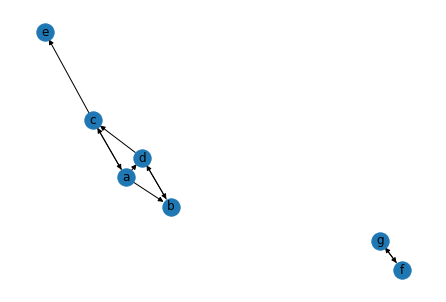

In [ ]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.show()


Ok, this is not nearly as pretty as what we generated by hand, but it will have to do. 

## One-Step Reachability and Graph Representations

What are conceivable operations on graphs?  There are some basic ones, such as adding a vertex and adding an edge.  These are easily taken care of.

In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)

    def add_edge(self, e):
        self.edges.add(e)


Further, a graph represents a set of connections between vertices, so a very elementary question to ask is the following: if we are at vertex $v$, can we get to another vertex $u$ by following one or more edges? 
 
As a first step towards the solution, we want to compute the set of vertices reachable from $v$ in one step, by following one edge; we call these vertices the _successors_ of $v$. 

Writing a function g.successors(u) that returns the set of successors of $u$ is simple enough.  Note that the code directly mimicks the mathematical definition: 

$$
\mathit{Successors}(u) = \{v \in V \mid (u, v) \in E\} \; .
$$

In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        # We use set below, just in case somebody passes a list to the initializer.
        self.vertices = set(vertices or [])
        self.edges = set(edges or [])

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from(self.edges)
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)

    def add_edge(self, e):
        self.edges.add(e)

    def successors(self, u):
        """Returns the set of successors of vertex u"""
        return {v for v in self.vertices if (u, v) in self.edges}


set()

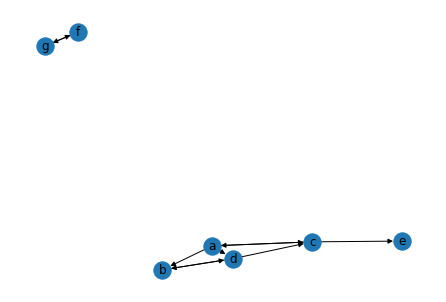

In [ ]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.show()
g.successors('e')


But there's a rub.  The method successors, as written, requires us to loop over the whole set of vertices.  Because self.edges is a set, represented as a hash table, once we have a pair (u, v), checking 

    (v, u) in self.edges
    
is efficient.  But typically, graphs have a locality structure, so that each node is connected only to a small subset of the total vertices; having to loop over all vertices to find the successors of a vertex is a great waste. 
It is as if I asked you to what places you can get from San Francisco with a direct flight, and to answer, you started to rattle off all of the world's cities, from Aachen, Aalborg, Aarhus, ..., all the way to Zürich, Zuwarah, Zwolle, and for each city you checked if there's a flight from San Francisco to that city!  Clearly not the best method.

Given that our main use for graphs is to answer reachability-type questions, a better idea is to store the edges via a dictionary that associates with each vertex the set of successors of the vertex.  The vertices will simply be the keys of the dictionary.


In [ ]:
import networkx as nx # Library for displaying graphs.
from collections import defaultdict

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        self.s = {u: set() for u in vertices or []}
        for u, v in (edges or []):
            self.add_edge((u, v))

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.s.keys())
        g.add_edges_from([(u, v) for u in self.s for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        if v not in self.s:
            self.s[v] = set()

    def add_edge(self, e):
        u, v = e
        self.add_vertex(u)
        self.add_vertex(v)
        self.s[u].add(v)

    @property
    def vertices(self):
        return set(self.s.keys())

    def successors(self, u):
        """Returns the set of successors of vertex u"""
        return self.s[u]


{'c', 'b', 'd'}


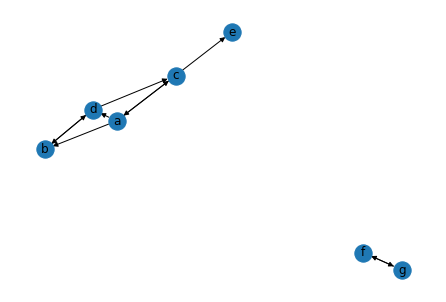

In [ ]:
g = Graph(vertices={'a', 'b', 'c', 'd', 'e', 'f', 'g'},
          edges={('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'd'),
                 ('c', 'a'), ('c', 'e'), ('d', 'b'), ('d', 'c'),
                 ('f', 'g'), ('g', 'f')})
g.show()
print(g.successors('a'))


## Graph Reachability

We now come to one of the fundamental graph algorithms, in fact, perhaps _the_ most fundamental algorithm for graphs: computing the set of vertices reachable from a given starting vertex.  Exploring what is reachable from a graph vertex is a truly basic task, and variations on the algorithm can be used to answer related questions, such as whether a vertex is reachable from a given starting vertex. 

The algorithm keeps two sets of vertices: 

* The set of _open_ vertices: these are the vertices that are known to be reachable, and whose successors have not yet been explored. 
* The set of _closed_ vertices: these are the vertices that are known to be reachable, and whose successors we have already explored. 

Intially, the set of open vertices contains only the starting vertex, and the set of closed vertices is empty, as we have completed no exploration. 
Repeatedly, we pick an open vertex, we move it to the closed set, and we put all its successor vertices -- except those that are closed already -- in the open set.   The algorithm continues until there are no more open vertices; at that point, the set of reachable vertices is equal to the closed vertices.  

If there is _one_ graph algorithm that you must learn by heart, and that you should be able to write even when you hang upside down from monkeybars, this is it.

Let us write the algorithm as a function first. 


In [ ]:
def reachable(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    vopen = {v}
    vclosed = set()
    while len(vopen) > 0:
        u = vopen.pop()
        vclosed.add(u)
        vopen.update(g.successors(u) - vclosed)
    return vclosed


In [ ]:
print(reachable(g, 'a'))
print(reachable(g, 'g'))


{'a', 'c', 'e', 'd', 'b'}
{'f', 'g'}


To visualize the algorithm, let us write a version where at each iteration, open vertices are drawn in red and closed ones in green

In [ ]:
import matplotlib.pyplot as plt
def color_draw(g, vopen, vclosed):
    gg = nx.DiGraph()
    gg.add_nodes_from(g.vertices)
    gg.add_edges_from([(u, v) for u in g.vertices for v in g.successors(u)])
    node_colors = ''.join([('r' if v in vopen else 'g' if v in vclosed else 'b')
                           for v in g.vertices])
    nx.draw(gg, with_labels=True, node_color=node_colors)
    plt.show()

def reachable(g, v):
    """Given a graph g, and a starting vertex v, returns the set of states
    reachable from v in g."""
    vopen = {v}
    vclosed = set()
    color_draw(g, vopen, vclosed)
    while len(vopen) > 0:
        u = vopen.pop()
        vclosed.add(u)
        vopen.update(g.successors(u) - vclosed)
        color_draw(g, vopen, vclosed)
    return vclosed


/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:478: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  label=label,


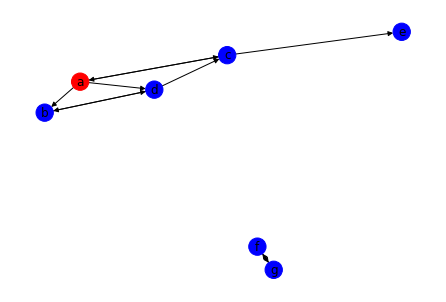

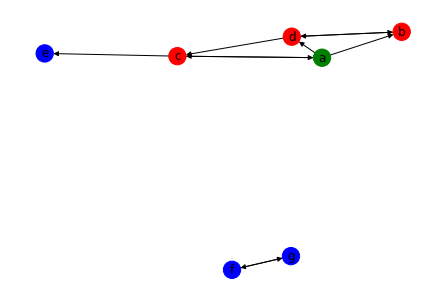

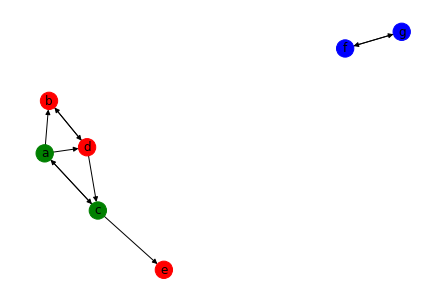

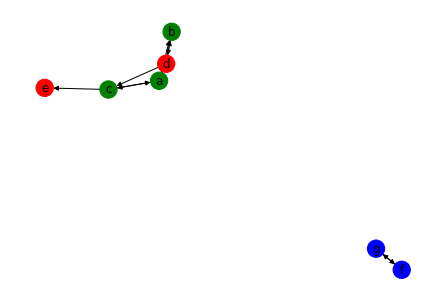

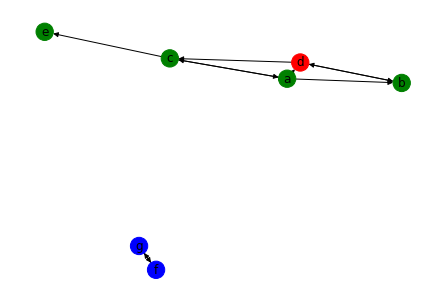

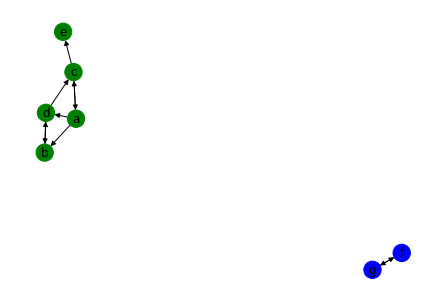

{'a', 'b', 'c', 'd', 'e'}

In [ ]:
reachable(g, 'a')


Great!  Let's now endow our graph with a method that yields the vertices reachable from any given starting vertex.

In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        self.s = {u: set() for u in vertices or []}
        for u, v in (edges or []):
            self.add_edge((u, v))

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.s.keys())
        g.add_edges_from([(u, v) for u in self.s for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        if v not in self.s:
            self.s[v] = set()

    def add_edge(self, e):
        u, v = e
        self.add_vertex(u)
        self.add_vertex(v)
        self.s[u].add(v)

    @property
    def vertices(self):
        return set(self.s.keys())

    def successors(self, u):
        """Returns true iff one can get from vertex v to vertex u by following
        one edge."""
        return self.s[u]

    def __eq__(self, other):
        """We need to define graph equality."""
        if self.vertices != other.vertices:
            return False
        for v, d in self.s.items():
            if d != other.s[v]:
                return False
        return True

    def __repr__(self):
        r = "Graph:"
        for v in self.vertices:
            r += "\n %r : %r" % (v, self.s.get(v))
        return r

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from([(u, v) for u in self.vertices for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)
        # We must be careful not to overwrite the successor relation
        # in case v might already be present in the graph.
        self.s[v] = self.s.get(v, set())

    def add_edge(self, e):
        """Adds an edge e = (u, v) between two vertices u, v.  If the
        two vertices are not already in the graph, adds them."""
        u, v = e
        self.vertices.update({u, v})
        # Initializes the successor function if needed.
        self.s[u] = self.s.get(u, set()) | {v}
        self.s[v] = self.s.get(v, set())

    def successors(self, u):
        """Returns the set of successors of a vertex u"""
        return self.s[u]

    def reachable(self, v):
        """Returns the set of vertices reachable from an initial vertex v."""
        vopen = {v}
        vclosed = set()
        while len(vopen) > 0:
            u = vopen.pop()
            vclosed.add(u)
            vopen.update(self.s[u] - vclosed)
        return vclosed


### Testing the implementation

This seems to be a reasonable implementation.  Let us do some tests, to check that everything works as expected.  The nose tools are very handy for testing.
We have written a _check function that enables us to test whether the definition of a graph is self consistent.  Writing such consistency checks is very useful.  In development, we may call them often.  In production code, we may choose to call them at key points in the code, to prevent the propagation of errors to distant places in the code. 

In [ ]:
import random


Let's build constructors for random graphs.

In [ ]:
vertices = list('abcdefghilmnopqrstuvz')

def random_vertices():
    """Returns a set of random vertices."""
    return set(random.choices(vertices, k=12))

def random_edges(vs):
    """Returns a set of random edges, given a set of vertices."""
    vxv = [(u, v) for u in vs for v in vs]
    return set(random.choices(vxv, k=min(len(vxv), 50)))

def random_graph():
    vs = random_vertices()
    e = random_edges(vs)
    return Graph(vertices=vs, edges=e)


We can create random graphs.

In [ ]:
for _ in range(100):
    g = Graph()
    vs = random_vertices()
    es = random_edges(vs)
    for e in es:
        g.add_edge(e)


Let's check that the graph we obtain does not depend on the order with which we add the vertices and edges.

In [ ]:
for _ in range(100):
    vs = random_vertices()
    es = list(random_edges(vs))
    g1 = Graph(vertices=vs, edges=es)
    g2 = Graph(vertices=vs)
    g3 = Graph(vertices=vs)
    esp = es[:] # Creates a copy.
    random.shuffle(esp)
    for e in es:
        g2.add_edge(e)
    for e in esp:
        g3.add_edge(e)
    assert g1 == g2
    assert g1 == g3


## Graph Operations

What are useful, general graph operations we may implement?  Here are a few. 

*   **Union** and **intersection**. 
*   **Induced:** given a graph $G = (V, E)$ and a set of vertices $U$, we return the graph with set of vertices $V \cap U$ and set of edges $E \cap (V\cap U \times V \cap U)$. This is the portion of the original graph that only involves vertices in V. 
* **Difference:** Remove, from a graph $G$, all vertices in a specified set $U$, along with the edges that have an endpoint in $U$. 

We will have you implement graph union. 

In [ ]:
import networkx as nx # Library for displaying graphs.

class Graph(object):

    def __init__(self, vertices=None, edges=None):
        self.s = {u: set() for u in vertices or []}
        for u, v in (edges or []):
            self.add_edge((u, v))

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.s.keys())
        g.add_edges_from([(u, v) for u in self.s for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        if v not in self.s:
            self.s[v] = set()

    def add_edge(self, e):
        u, v = e
        self.add_vertex(u)
        self.add_vertex(v)
        self.s[u].add(v)

    @property
    def vertices(self):
        return set(self.s.keys())

    @property
    def edges(self):
        return {(u, v) for u, d in self.s.items() for v in d}

    def successors(self, u):
        """Returns the set of successors of vertex u"""
        return self.s[u]

    def __eq__(self, other):
        """We need to define graph equality."""
        if self.vertices != other.vertices:
            return False
        for v, d in self.s.items():
            if d != other.s[v]:
                return False
        return True

    def __repr__(self):
        r = "Graph:"
        for v in self.vertices:
            r += "\n %r : %r" % (v, self.s.get(v))
        return r

    def show(self):
        g = nx.DiGraph()
        g.add_nodes_from(self.vertices)
        g.add_edges_from([(u, v) for u in self.vertices for v in self.s[u]])
        nx.draw(g, with_labels=True)

    def add_vertex(self, v):
        self.vertices.add(v)
        # We must be careful not to overwrite the successor relation
        # in case v might already be present in the graph.
        self.s[v] = self.s.get(v, set())

    def add_edge(self, e):
        """Adds an edge e = (u, v) between two vertices u, v.  If the
        two vertices are not already in the graph, adds them."""
        u, v = e
        self.vertices.update({u, v})
        # Initializes the successor function if needed.
        self.s[u] = self.s.get(u, set()) | {v}
        self.s[v] = self.s.get(v, set())

    def successors(self, u):
        """Returns the set of successors of a vertex u"""
        return self.s[u]

    def reachable(self, v):
        """Returns the set of vertices reachable from an initial vertex v."""
        vopen = {v}
        vclosed = set()
        while len(vopen) > 0:
            u = vopen.pop()
            vclosed.add(u)
            vopen.update(self.s[u] - vclosed)
        return vclosed

    def __and__(self, g):
        """Returns the intersection of the current graph with a
        specified graph g."""
        return Graph(vertices=self.vertices & g.vertices,
                     edges=self.edges & g.edges)

    def induced(self, vertex_set):
        """Returns the subgraph induced by the set of vertices vertex_set."""
        common_vertices = vertex_set & self.vertices
        gg = Graph(vertices = common_vertices)
        for v in common_vertices:
            gg.s[v] = self.s[v] & common_vertices
        gg._check()
        return gg


## Question 1: Is a graph a tree? 

A tree is a graph $(V, E)$ with two special properties: 

* Every vertex has at most one incoming edge.
* Either there are no vertices, or there is a vertex with no incoming edges, called the _root_, from which all other vertices are reachable. 

If the second property does not hold, incidentally, the graph is called a _forest._

Write an `is_tree` property that has value True if the graph is a tree, and has value False otherwise.

In [ ]:
"""def graph_is_tree(self): # Implementation of property 1 ( Every node can 
have at most 1 incoming edges) for key in self.s.keys(): if key in self.s[key]: 
# checking for self loop. (if graph has self loop then it can not be a tree) 
count=0 return False temp=dict((k,val) for k,val in self.s.items() if k!=key) 
# temp holds the vertices other than the selected vertics. print(temp) 
for k in temp.keys(): count=0 if key in self.s[k]: count+=1 # increament when
 got a incoming edges for the vertices(key) . if count>1: # Got more than one 
 incoming edges for selected vertics hence not Tree. return False 
 if count==len(self.s.keys()): # every vertices has exactly one incoming 
 edge(#edges=#vertices) but a graph will be a tree if #of vertices <= #edges-1 
 .this property not holds for this case hence it is not a tree. return False
  else: if count<len(self.s.keys())-1: return True # the graph is a tree for 
  this case."""

'def graph_is_tree(self): # Implementation of property 1 ( Every node can \nhave at most 1 incoming edges) for key in self.s.keys(): if key in self.s[key]: \n# checking for self loop. (if graph has self loop then it can not be a tree) \ncount=0 return False temp=dict((k,val) for k,val in self.s.items() if k!=key) \n# temp holds the vertices other than the selected vertics. print(temp) \nfor k in temp.keys(): count=0 if key in self.s[k]: count+=1 # increament when\n got a incoming edges for the vertices(key) . if count>1: # Got more than one \n incoming edges for selected vertics hence not Tree. return False \n if count==len(self.s.keys()): # every vertices has exactly one incoming \n edge(#edges=#vertices) but a graph will be a tree if #of vertices <= #edges-1 \n .this property not holds for this case hence it is not a tree. return False\n  else: if count<len(self.s.keys())-1: return True # the graph is a tree for \n  this case.'

In [ ]:
 #@title Implementation of tree test

def graph_is_tree(self):
    """Returns True iff the graph is a tree."""
    ### YOUR CODE HERE
    if not self.vertices:
        return True
    if self.vertices == set: 
        return True

    incoming_edge = [x for i, x in self.edges]
    if len(incoming_edge) != len(set(incoming_edge)): 
        return False

    for i in self.vertices:
        val = self.reachable(i)
        if set(self.vertices) == val:
            for i2 in self.vertices:
                if i2 == i:
                    continue
                    
                val2 = self.reachable(i2)
                if i in val2:
                    break
                    
            else:
                return True
    return False    

Graph.is_tree = property(graph_is_tree)    

Graph.is_tree = property(graph_is_tree)


In [ ]:
# You may want to write tests here. 

### YOUR CODE HERE

In [ ]:
 ### 10 points: Tests for tree. 

g = Graph(vertices=[1, 2, 3], edges=[(1, 2), (1, 3)])
assert g.is_tree

g = Graph(vertices=[1, 2, 3], edges=[(1, 2), (2, 3), (1, 3)])
assert not g.is_tree

g = Graph(vertices=[1, 2, 3], edges=[(1, 3), (2, 3)])
assert not g.is_tree

g = Graph(vertices=['a', 'b'], edges=[('a', 'b')])
assert g.is_tree

g = Graph(vertices=['a', 'b'], edges=[('a', 'b'), ('b', 'a')])
assert not g.is_tree


In [ ]:
### 10 points: Hidden tests for is_tree


In [ ]:
### 10 points: More tests for `is_tree`

g = Graph()
assert g.is_tree

g = Graph(vertices=['a', 'b', 'c', 'd'], edges=[('a', 'b'), ('c', 'd')])
assert not g.is_tree

g = Graph(vertices=['a', 'b', 'c', 'd'], edges=[('a', 'b'), ('b', 'c'), ('c', 'd')])
assert g.is_tree

In [ ]:
## 10 points: More hidden tests for `is_tree`


## Question 2: Count the Islands

You need to write a function `count_the_islands`, which counts the islands of 1s in a matrix whose elements can be 0 or 1.  Two 1s belong to the same island if they are adjacent horizontally or vertically.  For example, the matrix: 

    000000000
    001000001
    011110011
    001100110
    000000000
    
contains two islands: 

    .........
    ..1......
    .1111....
    ..11.....
    .........
    
and 

    .........
    ........1
    .......11
    ......11.
    .........
    
As another example, the matrix: 

    00010000
    00001100
    00000000
    
contains two islands, one containing one 1, the other containing two 1s, as being adjacient via the diagonal only does not count. 

Your task is simple: write a function that, given as input a numpy matrix containing 0/1, returns an integer, indicating the number of islands.  You should not modify the matrix that is passed to you.

### Hint

There are two ways to solve this problem. 

The first way consists in translating the matrix into a graph, where each node represents a position in the matrix containing a 1.  For instance, the second matrix above would be translated into a graph with nodes (0, 3), (1, 4), (1, 5).  Edges connect adjacent nodes.  You can then use the algorithm for graph reachability to tell which nodes belong to the same island. 

The second way consists in implementing the reachability algorithm on top of the matrix directly. 

You can choose either way. 

Note that if you have a matrix `a` as above, 

    np.argwhere(a)
    
returns the positions in `a` that are 1.

In [ ]:
"""attempt at Q2 psuedocode
nodes = list of map(tuple,np.argwhere(m))
neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
new list of edges
count = 0
loop through nodes
    loop through neighbors
           x = add tuples of node and neighbor together
           if x in nodes
                   append (node,x) to new list of edges
Graph nodes and edges
reachable = set
loop  i through vertices of graph
       test if i in reachable if so continue
       reachable  = union of reachable and graph.reachable(i)
       count +=1
return count """

'attempt at Q2 psuedocode\nnodes = list of map(tuple,np.argwhere(m))\nneighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]\nnew list of edges\ncount = 0\nloop through nodes\n    loop through neighbors\n           x = add tuples of node and neighbor together\n           if x in nodes\n                   append (node,x) to new list of edges\nGraph nodes and edges\nreachable = set\nloop  i through vertices of graph\n       test if i in reachable if so continue\n       reachable  = union of reachable and graph.reachable(i)\n       count +=1\nreturn count '

In [ ]:
import numpy as np

# You can define here any auxiliary function you wish. 
### YOUR CODE HERE

def count_the_islands(m):
    """Returns the number of islands in the matrix m."""
    # My solution takes 14 lines of code. 
    ### YOUR CODE HERE
    nodes = list(map(tuple, np.argwhere(m)))
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    edges = list()
    count = 0

    for nod in nodes:
        for nei in neighbors:
            x = tuple(map(sum, zip(nod, nei)))
            if x in nodes:
                edges.append((nod,x))
                
    graph = Graph(nodes, edges)
    reachable = set()
    for i in graph.vertices:
        if i in reachable:
            continue 
        reachable = reachable | graph.reachable(i)
        count += 1 
    return count
    

In [ ]:
### You can write your own tests here. 

### YOUR CODE HERE

In [ ]:
### 4 points: simple tests. 

a = np.array([
    [0, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 1],
    [0, 1, 0, 0, 1, 1]
])
assert count_the_islands(a) == 2

a = np.zeros((10, 12))
assert count_the_islands(a) == 0

a = np.ones((10, 12))
assert count_the_islands(a) == 1

a = np.array([
    [0, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 1],
    [0, 1, 0, 0, 1, 1],
    [0, 1, 1, 0, 0, 1],
    [0, 1, 0, 0, 1, 1]

])
assert count_the_islands(a) == 2
assert count_the_islands(1 - a) == 2

a = np.identity(7)
assert count_the_islands(a) == 7
assert count_the_islands(a) == 7
assert (a == np.identity(7)).all()


In [ ]:
### More advanced, hidden tests.  6 points. 
